# Convolutional Neural Networks (LeNet)

In [29]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

import matplotlib.pyplot as plt

## LeNet

At a very high level, LeNet consists of two components:
1. Convolutional layers, of which there are two
2. Dense, fully connected layers, eventually leading to 10 outputs for digit recognicition.

In each convolutional block, there's a convolutional layer, a sigmoid activation, and an average pooling. Note: ReLU activation an max-pooling actually work better, but had not yet been invented. Each convolutional layer uses a 5x5 kernel. Typically, these increase the number of channels, with the first having an output of 6 channels, and the second 16, while reducing the spatial resolution b a factor of 4. 

The outputs of the final convolutional block are flattened, so that there can be a fully-connected block with 120, 84 and 10 outputs. "

In [2]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 6, kernel_size = 5, padding = 2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels = 16, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

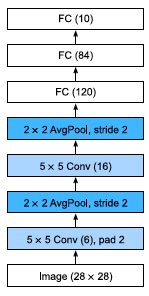

In [3]:
@d2l.add_to_class(d2l.Classifier)

def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [4]:
model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/home/patrick/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Height and width reduced layer over layer. Second convolutional layer does not include padding, so height and width reduced by four pixels. 

## Training

In [6]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(train=True)))[0]], init_cnn)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



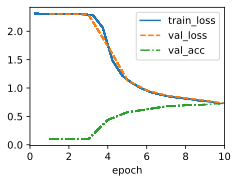

In [7]:
trainer.fit(model, data)

In [218]:
def get_layer_weights(conv_layer, input_weights=False):
    print(conv_layer.__class__.__name__)
    print(conv_layer.weight[0].shape)
    inx = 1 if input_weights else 0
    layers = [channel.reshape((channel.shape[-2], channel.shape[-1])).cpu().detach().numpy() for channel in conv_layer.weight[:, inx]]
    return layers

In [223]:
def plot_layer_weights(layer_weights):
    ax = plt.subplot()
    ax.imshow(layer_weights, cmap='gray')
    return ax

def plot_channels(channel_weights):
    gridsize = int(len(channel_weights) ** 0.5)

    # Figure out if we need an extra column
    ncols, nrows = gridsize, gridsize
    if gridsize ** 2 < len(channel_weights):
        ncols +=  1 
        
    figure, axes = plt.subplots(ncols=ncols, nrows=nrows)
    
    for i, layer_weights in enumerate(channel_weights):
        ax = axes.ravel()[i]
        ax.imshow(layer_weights, cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    for j, ax in enumerate(axes.ravel()):
        if j > i:
            ax.set_axis_off()
    
    
    return figure, axes                                


Conv2d
torch.Size([1, 5, 5])


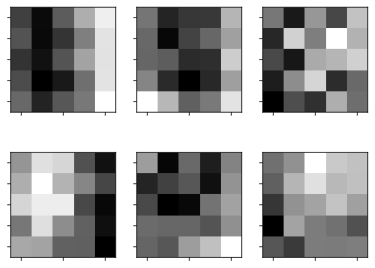

In [224]:
fig, ax = plot_channels(get_layer_weights(model.net[0]))

In [225]:
model.net[3].weight.shape

torch.Size([16, 6, 5, 5])

Conv2d
torch.Size([6, 5, 5])


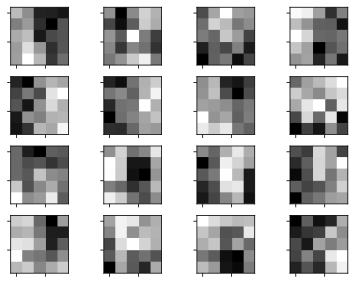

In [226]:
fig, ax = plot_channels(get_layer_weights(model.net[3]))